In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 16.0 MB/s eta 0:00:00


In [2]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 41.1 MB/s eta 0:00:00


# Load Libraries

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import nltk
import re
import os
import emoji
import time
from string import punctuation

from pymorphy3 import MorphAnalyzer
from IPython.core.display import display, HTML
from nltk.corpus import stopwords
from collections import defaultdict
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm


from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

RANDOM_SEED = 42

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
data_path = '/content/gdrive/MyDrive/Colab_Notebooks/Stocks_project/data'

# Load Data

In [33]:
data = pd.read_csv(os.path.join(data_path,'news_high_rep_tickers_two_channels.csv'))
data.head()

,message_id,channel_db_table,date_published,text,AFKS,AFLT,ASTR,CHMF,FESH,GAZP,...,POSI,RNFT,ROSN,RTKM,RUAL,SBER,SFIN,SNGS,VTBR,YNDX
0,6,messages_newssmartlab,2021-03-29 15:31:02,Менеджмент ЛСР будет постепенно повышать дивид...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13,messages_grigorievspy,2024-01-05 18:15:36,⬆️ #GAZP 57.63M₽ +0.22%\nГазпром\nОбъём: 57.63...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,14,messages_newssmartlab,2021-03-29 17:05:22,ЛСР выходит на рынок коттеджного строительства,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,messages_grigorievspy,2024-01-05 18:45:13,⬇️ #SBER 133.22M₽ 0.0%\nСбер Банк\nОбъём: 133....,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,20,messages_grigorievspy,2024-01-05 19:25:56,⬇️ #ROSN 26.58M₽ -0.01%\nРоснефть\nОбъём: 26.5...,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [34]:
tickers = [col for col in data.columns if col != "message_id" and col != "channel_db_table" and col != "date_published" and col != "text"]
f'Количество тикеров: {len(tickers)}'

'Количество тикеров: 24'

In [35]:
absolute_counts = data[tickers].sum()
total_news = len(data)
percentage_counts = (absolute_counts / total_news) * 100
result = pd.DataFrame({
    'Ticker': tickers,
    'Absolute Count': absolute_counts.values,
    'Percentage': percentage_counts.values
})

result = result.sort_values(by='Absolute Count', ascending=False)
pd.set_option('display.max_rows', None)
result

,Ticker,Absolute Count,Percentage
4,FESH,3502,8.834956
5,GAZP,3258,8.219385
15,RNFT,3217,8.115949
7,LSRG,2751,6.940310
0,AFKS,2269,5.724305
1,AFLT,1789,4.513346
16,ROSN,1782,4.495686
23,YNDX,1604,4.046622
20,SFIN,1552,3.915435
19,SBER,1546,3.900298


In [36]:
pd.reset_option('display.max_rows')

In [37]:
info = pd.Series({'Number of news': data.shape[0],
                        'Number of tickers': len(tickers),
                        'Number of telegram channels': data.channel_db_table.nunique(),
                        'The earliest datetime value': data.date_published.min(),
                        'The latest datetime value': data.date_published.max()
                      })

# Convert the series to a DataFrame
info = pd.DataFrame(info, columns=['values'])
info

,values
Number of news,39638
Number of tickers,24
Number of telegram channels,2
The earliest datetime value,2021-03-29 15:31:02
The latest datetime value,2024-06-12 10:23:30


In [38]:
class_sums = data[tickers].sum()

fig = px.bar(
    x=class_sums.index,
    y=class_sums.values,
    title=f"News Distribution by Tickers",
    labels={"x": "Ticker", "y": "Number of News"},
    template="plotly_white"
)


fig.update_xaxes(
    title="Tickers",
    tickangle=45,
    tickfont=dict(size=10),
    automargin=True
)


fig.update_yaxes(
    title="Number of News",
    tickformat=","
)


fig.update_layout(
    width=1200,
    height=500,
    bargap=0.1,
)

fig.show()

The distribution is noticeably imbalanced. The top ticker, FESH, contributes 8.83%, while the lowest, PLZL, contributes only 2.75%

# Split Data

We set 80% of the total data as the training dataset, reserving the remaining 20% for testing, and then further split the training dataset into training and validation subsets.

In [12]:
# Разделение данных
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
train, valid = train_test_split(train, test_size=0.2, random_state=RANDOM_SEED)

In [13]:
data = {
    'train': [f'{train.shape[0]} ({len(train) / len(data) * 100:.0f}%)'],
    'valid': [f'{valid.shape[0]} ({len(valid) / len(data) * 100:.0f}%)'],
    'test': [f'{test.shape[0]} ({len(test) / len(data) * 100:.0f}%)']
}

df_percentages = pd.DataFrame(data)
df_percentages

,train,valid,test
0,25368 (64%),6342 (16%),7928 (20%)


In [14]:
train.to_csv(os.path.join(data_path,'train_data.csv'), index=False)
test.to_csv(os.path.join(data_path,'test_data.csv'), index=False)
valid.to_csv(os.path.join(data_path,'valid_data.csv'), index=False)

# Classes Distribution in Train/Test/Valid

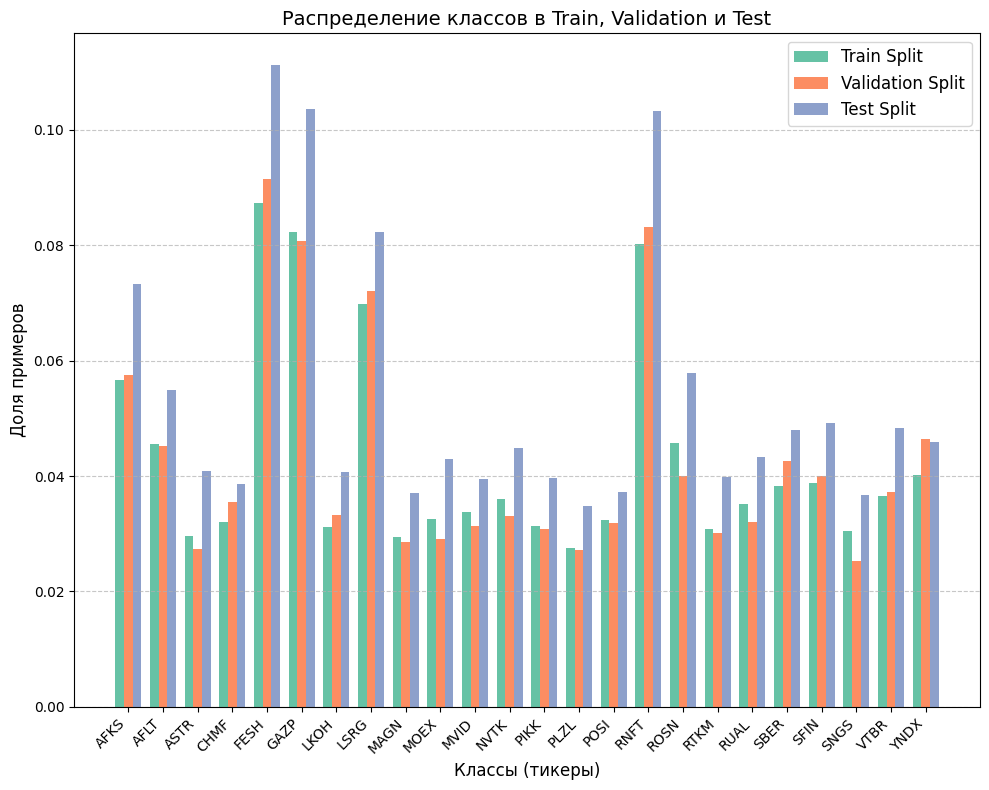

In [15]:
train_distribution = train[tickers].sum()
val_distribution = valid[tickers].sum()
test_distribution = test[tickers].sum()

# Нормализация распределения, чтобы показать доли
train_distribution_normalized = train_distribution / len(train)
val_distribution_normalized = val_distribution / len(valid)
test_distribution_normalized = test_distribution / len(valid)

# Установка цветов для сплитов
colors = sns.color_palette("Set2", 3)

fig, ax = plt.subplots(figsize=(10, 8))

# Ширина столбцов и их позиции
bar_width = 0.25
positions = np.arange(len(tickers))

# Построение гистограмм для Train, Validation и Test
ax.bar(positions - bar_width, train_distribution_normalized, width=bar_width, color=colors[0], label='Train Split')
ax.bar(positions, val_distribution_normalized, width=bar_width, color=colors[1], label='Validation Split')
ax.bar(positions + bar_width, test_distribution_normalized, width=bar_width, color=colors[2], label='Test Split')

# Установка меток и текста
ax.set_title('Распределение классов в Train, Validation и Test', fontsize=14)
ax.set_xlabel('Классы (тикеры)', fontsize=12)
ax.set_ylabel('Доля примеров', fontsize=12)
ax.set_xticks(positions)
ax.set_xticklabels(tickers, rotation=45, ha='right')
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Text Preprocess

In [16]:
from nltk.corpus import stopwords
nltk.download("stopwords")

mystopwords = stopwords.words('russian')
sorted(mystopwords)[:5]

mystopwords.extend(
    [
        'это',
        'так',
        'из',
        'из-за',
        'на',
        'ок',
        'кстати',
        'который',
        'мочь',
        'весь',
        'еще',
        'также',
        'самый',
        'среди',
        'кроме',
        'ранее',
        'пока',
        'свой',
        'наш',
        'например',
        'поэтому',
        'очень',
        'однако',
        'затем',
        'именно',
        'поскольку'
    ]
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
RUBBISH_PATTERN = r'Читать.+|Подключить бота-шпиона:?'
PATTERN_TAG = r'#\S+|\$[A-Z]{4}' #для тэгов тикеров, которые могут вводится через $
LINKS_PATTERN  = r"https?://\S+"

def remove_rubbish(text):
    return re.sub(RUBBISH_PATTERN, '', text)

def remove_links(text):
    return re.sub(LINKS_PATTERN, '', text)

def remove_emojis(text):
    return emoji.replace_emoji(text, " ")

def remove_tags(text):
    return re.sub(PATTERN_TAG, '', text)

def replace_numbers(text):
    return re.sub(r'\d+', '1', text)

def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', punctuation.replace('-', '') + '”„“«»†*\—/\\‘’'))
    text = re.sub(r'-(?=\s)', '', text) #we keep hyphens inside words, standalone ones are deleted
    return text

def clean_text(text):
    if not isinstance(text, str):
        return text
    else:
        text = re.sub(r'ё', 'е', text)
        text = remove_emojis(text)
        text = re.sub(r'\*+', '', text)
        text = remove_rubbish(text)
        text = remove_links(text)
        text = remove_tags(text)
        text = replace_numbers(text)
        text = re.sub(r'\n|\xa0', ' ', text)  # Replace newlines and non-breaking spaces
        text = re.sub(r'\s{2,}', ' ', text)  # Remove extra spaces
        text = remove_punctuation(text)
        text = text.strip()
        text = re.sub(r'^[+\-*/=<>!?\s]+$', '', text) # $YNDX + $MTSS = ? \n🤫
        return text

def tokenize(text, regex=re.compile("[а-яa-zё\d-]+", re.IGNORECASE)):
    try:
        tokens = regex.findall(text)
        # Tokens like "3D" or "G7" are not affected, while pure numeric tokens are removed
        tokens =  [(re.sub(r'^\d+$', '', token)) for token in tokens]
        tokens = [token for token in tokens if token.strip()]
        return tokens
    except:
        return []

def pymorphy_lemmatizer(tokens, pymorphy=MorphAnalyzer()):
    return [pymorphy.parse(token)[0].normal_form for token in tokens]

def remove_stopwords(lemmas, stopwords):
    return [w for w in lemmas if not w in stopwords]

def lemmatize(text, delete_stopwords=True, stopwords=None):
    tokens = tokenize(text)
    lemmas = pymorphy_lemmatizer(tokens)
    lemmas = [re.sub('ё', 'е', lemma) for lemma in lemmas]

    if delete_stopwords and stopwords is not None:
        lemmas = remove_stopwords(lemmas, stopwords=stopwords)

    return ' '.join(lemmas)


def preprocess_text(df, stopwords=None, delete_stopwords=True, make_lemmatization=True):
    df['text_cleaned'] = df.text.progress_apply(clean_text)
    if make_lemmatization==True:
        df['lemmas'] = df['text_cleaned'].progress_apply(
            lambda x: lemmatize(x, stopwords=stopwords, delete_stopwords=delete_stopwords)
        )
    else:
       df['tokens'] = df['text_cleaned'].progress_apply(tokenize)
    return df

In [18]:
preprocessed_train = preprocess_text(train, stopwords=mystopwords, delete_stopwords=True, make_lemmatization=False)
preprocessed_test = preprocess_text(test, stopwords=mystopwords, delete_stopwords=True, make_lemmatization=False)

100%|██████████| 7928/7928 [00:01<00:00, 7539.16it/s]


In [19]:
preprocessed_valid = preprocess_text(valid, stopwords=mystopwords, delete_stopwords=True, make_lemmatization=False)

100%|██████████| 6342/6342 [00:00<00:00, 18144.08it/s]


In [20]:
preprocessed_train[['text', 'text_cleaned', 'tokens']]

,text,text_cleaned,tokens
33503,⬇️ #SNGS 55.72M₽ -0.65%\nСургутнефтегаз\nОбъём...,11M₽ -11 Сургутнефтегаз Объем 11M₽ 1 лотов Пок...,"[11M, -11, Сургутнефтегаз, Объем, 11M, лотов, ..."
17216,⬇️ #FESH 34.62M₽ -0.33%\nДВМП\nОбъём: 34.62M₽ ...,11M₽ -11 ДВМП Объем 11M₽ 1 лотов Покупка 1 Про...,"[11M, -11, ДВМП, Объем, 11M, лотов, Покупка, П..."
32511,⬆️ #RUAL 40.6M₽ +0.21%\nРУСАЛ\nОбъём: 40.6M₽ (...,11M₽ 11 РУСАЛ Объем 11M₽ 1 лотов Покупка 1 Про...,"[11M, РУСАЛ, Объем, 11M, лотов, Покупка, Прода..."
876,⬆️ #CHMF 26.05M₽ +0.25%\nСеверсталь\nОбъём: 26...,11M₽ 11 Северсталь Объем 11M₽ 1 лотов Покупка ...,"[11M, Северсталь, Объем, 11M, лотов, Покупка, ..."
15477,⬇️ #MVID 5.63M₽ -0.2%\nМ.видео\nОбъём: 5.63M₽ ...,11M₽ -11 Мвидео Объем 11M₽ 1 лотов Покупка 1 П...,"[11M, -11, Мвидео, Объем, 11M, лотов, Покупка,..."
...,...,...,...
32007,⬆️ #RNFT 66.39M₽ +0.14%\nРуссНефть\nОбъём: 66....,11M₽ 11 РуссНефть Объем 11M₽ 1 лотов Покупка 1...,"[11M, РуссНефть, Объем, 11M, лотов, Покупка, П..."
36606,С 10 ноября Московская биржа расширяет перечен...,С 1 ноября Московская биржа расширяет перечень...,"[С, ноября, Московская, биржа, расширяет, пере..."
11960,МНЕНИЕ: Перевод расчетов за газ в рубли может ...,МНЕНИЕ Перевод расчетов за газ в рубли может п...,"[МНЕНИЕ, Перевод, расчетов, за, газ, в, рубли,..."
6153,МНЕНИЕ: Акции Северстали смогут закрыть дивиде...,МНЕНИЕ Акции Северстали смогут закрыть дивиден...,"[МНЕНИЕ, Акции, Северстали, смогут, закрыть, д..."


In [21]:
def remove_empty_strings(data, column):
    data = data[data[column].str.strip().ne('')]
    return data

train = remove_empty_strings(train, 'text_cleaned')
test = remove_empty_strings(test, 'text_cleaned')

In [22]:
train.shape

(25368, 30)

In [23]:
test.shape

(7928, 30)

# Text Analysis

In [24]:
train_tokens = " ".join(train.text_cleaned.tolist()).split()
test_tokens = " ".join(test.text_cleaned.tolist()).split()
valid_tokens = " ".join(valid.text_cleaned.tolist()).split()

In [25]:
train_tokens[:5]

['11M₽', '-11', 'Сургутнефтегаз', 'Объем', '11M₽']

In [26]:
data_df = {
    'Train': {
        'Number of docs in the corpus': len(train),
        'Number of tokens': len(train_tokens),
        'Size of vocabulary': len(set(train_tokens))
    },

    'Validaion': {
        'Number of docs in the corpus': len(valid),
        'Number of tokens': len(valid_tokens),
        'Size of vocabulary': len(set(valid_tokens))
    },

    'Test': {
        'Number of docs in the corpus': len(test),
        'Number of tokens': len(test_tokens),
        'Size of vocabulary': len(set(test_tokens))
    },
}

# Create DataFrame from the data
info_text_df = pd.DataFrame(data_df)
info_text_df

,Train,Validaion,Test
Number of docs in the corpus,25368,6342,7928
Number of tokens,588295,147493,180730
Size of vocabulary,21169,9582,10087


In [27]:
def predict_evaluate(X_test, y_test, model, model_name, vectorizer_name):
    start_time = time.time()
    y_pred = model.predict(X_test)
    predicting_time = time.time() - start_time
    f1score = round(f1_score(y_test, y_pred, average='macro'),3)

    result_df = pd.DataFrame({
        'model': [model_name],
        'vectorizer': [vectorizer_name],
        'f1_macro_score': [f1score],
        'predicting time': [predicting_time]
    })

    print(f'F1 Score Macro Average: {f1score}')
    print(classification_report(y_test, y_pred, target_names=tickers))

    return result_df, y_pred

Dataframe for keeping results

In [28]:
summary = pd.DataFrame(columns=['model', 'vectorizer', 'f1_macro_score', 'predicting time'])

In [29]:
#features
X_train = [' '.join(tokens) for tokens in preprocessed_train.tokens]
X_test = [' '.join(tokens) for tokens in preprocessed_test.tokens]

#targets
y_train = preprocessed_train[tickers].values
y_test = preprocessed_test[tickers].values

# Tf-idf

In [30]:
tfidf = TfidfVectorizer(max_features=15000, analyzer="word", ngram_range=(1, 2))
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# GridSearchCV with LogisticRegression wrapped in MultiOutputClassifier.

In [31]:
# Params for LogisticRegression
params = {
    "estimator__C": [0.1, 1, 10],
    "estimator__penalty": ["l2"]
}
# Model with MultiOutputClassifier
multi_target_lr = MultiOutputClassifier(LogisticRegression(random_state=RANDOM_SEED, max_iter=10000))

#  GridSearchCV
gs = GridSearchCV(multi_target_lr, params, cv=10, scoring='f1_macro', n_jobs=-1)

# Обучение GridSearchCV
gs.fit(X_train_tfidf, y_train)

# Лучший результат
print("Лучший параметр C:", gs.best_params_)
print("Лучшая оценка:", gs.best_score_)

Лучший параметр C: {'estimator__C': 10, 'estimator__penalty': 'l2'}
Лучшая оценка: 0.922176882638589


# Predictions

In [32]:
%%time
pipe = Pipeline([('tfidf', TfidfVectorizer(max_features=15000,
                                           analyzer="word",
                                           #stop_words=mystopwords,
                                           ngram_range=(1, 2))),
                 ('multi_target_cl', MultiOutputClassifier(LogisticRegression(C=10, penalty='l2', solver='saga',random_state=RANDOM_SEED,
                                            max_iter=10000, n_jobs=-1)))])

pipe.fit(X_train, y_train)

result_df, tfidf_preds = predict_evaluate(X_test, y_test, pipe, 'LogisticRegression', 'Tfidf')
summary = pd.concat([summary, result_df], ignore_index=True)
summary

F1 Score Macro Average: 0.934
              precision    recall  f1-score   support

        AFKS       1.00      0.96      0.98       465
        AFLT       1.00      0.93      0.96       348
        ASTR       1.00      0.94      0.97       259
        CHMF       1.00      0.84      0.92       245
        FESH       1.00      0.98      0.99       705
        GAZP       0.96      0.90      0.93       657
        LKOH       0.98      0.74      0.84       258
        LSRG       1.00      0.93      0.96       522
        MAGN       1.00      0.88      0.93       235
        MOEX       0.98      0.88      0.93       272
        MVID       1.00      0.94      0.97       250
        NVTK       0.92      0.78      0.84       285
        PIKK       0.99      0.82      0.90       252
        PLZL       1.00      0.85      0.92       221
        POSI       0.99      0.92      0.95       236
        RNFT       1.00      0.98      0.99       655
        ROSN       0.95      0.81      0.87       3

,model,vectorizer,f1_macro_score,predicting time
0,LogisticRegression,Tfidf,0.934,0.54122


In [52]:
example = "В моём портфеле доминируют акции Сбербанка, \
которые я докупал на хороших уровнях — Орловский в эфире РБК\n\nЧитать далее\n\n👉 https://smartlab.news/i/137263\n#SBER"

cleaned_text = clean_text(example)
predictions = pipe.predict([cleaned_text])
predicted_labels = [list(np.array(tickers)[pred == 1]) for pred in predictions]
print(predicted_labels)

[['SBER']]


# Conclusion

1. High F1 Scores for Most Classes: Many classes have very high F1 scores (e.g., AFKS, FESH, MVID), indicating that the model is handling them well in terms of precision and recall.

2. Class Imbalance Handling: The model shows good performance in most classes, though certain classes like LKOH, NVTK, and SBER have somewhat lower F1 scores. These might indicate issues with class imbalance, where the model might be underperforming for less frequent or harder-to-classify classes.

3. Micro vs. Macro Averages: The micro average F1 score of 0.94 indicates that the model performs well when considering all samples as a whole, while the macro average of 0.93 suggests a small difference between the classes' performances. This implies that the model is generally robust but might have occasional difficulty with smaller or more complex classes